In [25]:
%matplotlib inline


# 分位数回归
此示例说明了分位数回归如何预测非平凡的条件分位数。

左图显示了误差分布为正态但具有非恒定方差的情况，即具有异方差性。

右图显示了不对称误差分布的示例，即帕累托分布。

In [26]:
# Authors: David Dale <dale.david@mail.ru>
#          Christian Lorentzen <lorentzen.ch@gmail.com>
#          Guillaume Lemaitre <glemaitre58@gmail.com>
# License: BSD 3 clause

## 数据集生成
为了说明分位数回归的行为，我们将生成两个合成数据集。
两个数据集的真正生成随机过程将由具有与单个特征线性关系的相同期望值组成。 `x`.



In [42]:
import numpy as np

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x  #均值
print(x.shape, X.shape)
print(type(x),type(y_true_mean))

(100,) (100, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


我们将通过更改目标的分布同时保持相同的预期值来创建两个后续问题：y

在第一种情况下，添加异方差法向噪声;

在第二种情况下，增加了不对称帕累托噪声。

In [28]:
# 分布于均值两侧离散的点
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
# 不对称分布于均值两侧离散的点
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

让我们首先可视化数据集以及残差的分布。y - mean(y)


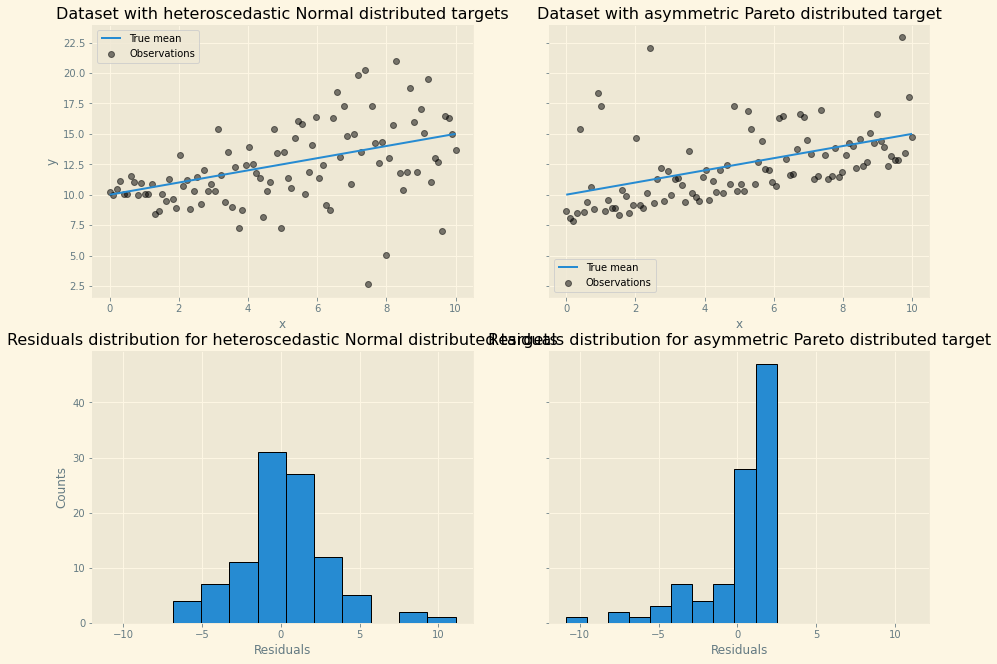

In [38]:
import matplotlib.pyplot as plt
plt.style.use(plt.style.available[0])

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")
#绘制均线
axs[0, 0].plot(x, y_true_mean, label="True mean")
#绘制两侧离散的点
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
#绘制条形图
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
_ = axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

对于异方差正态分布目标，我们观察到当特征值增加时，噪声的方差正在增加。x

对于不对称帕累托分布目标，我们观察到正残差是有界的。

这些类型的噪声目标使得通过线性回归的估计效率降低，即我们需要更多的数据来获得稳定的结果，
此外，大的异常值可能会对拟合系数产生巨大影响。
（否则：在具有恒定方差的设置中，普通最小二乘估计值随着样本量的增加而更快地收敛到真实系数。

在这种不对称设置中，中位数或不同的分位数提供了额外的见解。最重要的是，中位数估计对于异常值和重尾分布更加稳健。
但请注意，极端分位数是通过非常视图的数据点估计的。95%的分位数或多或少是由5%的最大值估计的，因此也是一个有点敏感的异常值。

在本教程的其余部分中，我们将展示如何在实践中使用QuantileRegressor，并将直觉提供给拟合模型的属性。
最后，我们将比较分位数回归器QuantileRegressor和线性回归器LinearRegression。

In the remainder of this tutorial, we will show how
:class:`~sklearn.linear_model.QuantileRegressor` can be used in practice and
give the intuition into the properties of the fitted models. Finally,
we will compare the both :class:`~sklearn.linear_model.QuantileRegressor`
and :class:`~sklearn.linear_model.LinearRegression`.

## 安装QuantileRegressor
在本节中，我们要估计条件中位数以及分别固定在 5% 和 95% 的低分位数和高分位数。
因此，我们将得到三个线性模型，每个分位数一个。

我们将使用 5% 和 95% 的分位数来查找训练样本中超出中心 90% 区间的异常值。



In [54]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

现在，我们可以绘制三个线性模型，以及位于中心 90% 区间内的可区分样本和超出此区间的样本。


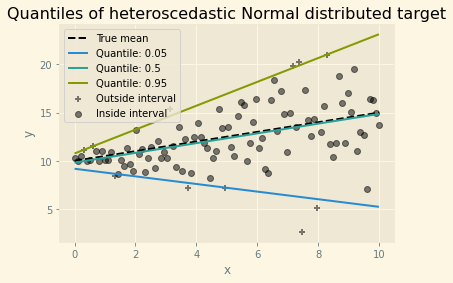

In [55]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

由于噪声仍然是正态分布的，特别是对称的，因此真条件均值和真条件中位数重合。
事实上，我们看到估计的中位数几乎达到了真实平均值。我们观察到噪声方差增加对5%和95%分位数的影响：
这些分位数的斜率非常不同，并且它们之间的间隔随着增加而变宽。x

为了获得关于5%和95%分位数估计器含义的额外直觉，可以计算预测分位数上方和下方的样本数量（由上图上的十字表示），
考虑到我们总共有100个样本。

我们可以使用不对称帕累托分布靶重复相同的实验。



In [52]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_pareto
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_pareto
        )

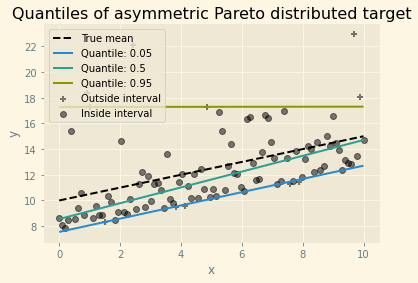

In [53]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

由于噪声分布的不对称性，我们观察到真实平均值和估计的条件中位数是不同的。我们还观察到，每个分位数模型都有不同的参数，以更好地拟合所需的分位数。
请注意，理想情况下，在这种情况下，所有分位数都是平行的，随着数据点或极端分位数的减少，例如10%和90%，这将变得更加明显。

## 比较 `QuantileRegressor` 和 `LinearRegression`

在本节中，我们将纠缠于有关分位数回归器和线性回归最小化的误差的差异。

实际上，线性回归是一种最小二乘法，可最大限度地减少训练目标和预测目标之间的均方误差 （MSE）。
相反，具有最小化绝对误差 （MAE） 的分位数回归器将最小化。quantile=0.5

让我们首先根据均方误差和平均绝对误差来计算此类模型的训练误差。
我们将使用不对称帕累托分布目标，使其更有趣，因为平均值和中位数不相等。


In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0)

y_pred_lr = linear_regression.fit(X, y_pareto).predict(X)
y_pred_qr = quantile_regression.fit(X, y_pareto).predict(X)

print(
    f"""Training error (in-sample performance)
    {linear_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_lr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_lr):.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_qr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_qr):.3f}
    """
)

Training error (in-sample performance)
    LinearRegression:
    MAE = 1.805
    MSE = 6.486
    QuantileRegressor:
    MAE = 1.670
    MSE = 7.025
    


在训练集上，我们看到分位数回归器的 MAE 低于线性回归。
与此相反，线性回归的MSE低于分位数回归器。这些结果证实 MAE 是分位数回归器最小化的损失，
而 MSE 是线性回归器最小化的损失。

我们可以进行类似的评估，但查看通过交叉验证获得的测试误差。


In [35]:
from sklearn.model_selection import cross_validate

cv_results_lr = cross_validate(
    linear_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
cv_results_qr = cross_validate(
    quantile_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
print(
    f"""Test error (cross-validated performance)
    {linear_regression.__class__.__name__}:
    MAE = {-cv_results_lr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_lr["test_neg_mean_squared_error"].mean():.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {-cv_results_qr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_qr["test_neg_mean_squared_error"].mean():.3f}
    """
)

Test error (cross-validated performance)
    LinearRegression:
    MAE = 1.732
    MSE = 6.690
    QuantileRegressor:
    MAE = 1.679
    MSE = 7.129
    


我们在样本外评估中得出了类似的结论。
